## 🎓 Persona : Léa, jeune investisseuse étudiante

**Profil :**
- 👩 24 ans, diplômée de l'EM Lyon
- 💼 Première expérience professionnelle après 2 ans d'alternance
- 💰 Aide parentale pour le financement + épargne personnelle (~15 000 €)
- 🎯 Objectif : réaliser un **premier investissement locatif** dans une **ville étudiante dynamique**

---

### 💡 Objectif d'investissement
> Trouver le **meilleur investissement locatif étudiant** possible avec un **budget global de 200 000 €**,  
> en ciblant un **studio à Lille**, tout en comparant brièvement avec un **T1 à Angers ou Nancy**.

---

### 💰 Hypothèses financières
| Élément | Montant estimé |
|----------|----------------|
| Prix d'achat visé | 160 000 – 180 000 € |
| Apport personnel | 15 000 € |
| Prêt immobilier estimé | 180 000 € sur 20 ans |
| Budget total (frais inclus) | **≈ 200 000 €** |
| Objectif de rentabilité brute | **≥ 5 %** |

---

### 🏙️ Cibles principales
| Ville | Type de bien | Prix moyen au m² | Loyer moyen mensuel | Observations |
|-------|---------------|------------------|---------------------|---------------|
| **Lille** | Studio (20–25 m²) | ~4 500 €/m² | 550–600 € | Marché étudiant tendu, forte demande locative |
| **Angers** | T1 (25–30 m²) | ~3 200 €/m² | 450–500 € | Ville très dynamique, bonne rentabilité brute |
| **Nancy** | T1 (25–30 m²) | ~2 800 €/m² | 420–470 € | Marché abordable, bon rapport prix/rentabilité |

---

### 🔍 Besoins data de Léa
- Identifier **les quartiers les plus rentables** à Lille (ou dans des villes comparables)
- Comparer avec **la rentabilité moyenne en France**
- Analyser l'**évolution du prix au m² et des loyers étudiants** depuis 5 ans
- Calculer la **rentabilité locative brute et nette** par quartier
- Visualiser les **zones à forte concentration étudiante**
- Fournir une **recommandation finale : "où investir avec 200k€ ?"**
- Évaluer le **taux de vacance locative** par quartier pour anticiper les périodes creuses (notamment l'été où les étudiants quittent les logements)
- Analyser la **proximité des transports en commun** et des universités/grandes écoles pour identifier les zones les plus attractives pour les étudiants
- Estimer les **charges de copropriété moyennes** par type de bien et par quartier pour affiner le calcul de rentabilité nette
- Identifier les **opportunités de biens nécessitant des travaux** (décote à l'achat) pour maximiser la plus-value à long terme

---

### 🧭 Objectif du notebook
Créer un outil interactif permettant à Léa de :
1. Comparer la rentabilité d'un **studio à Lille** avec celle d'un **T1 à Angers ou Nancy**  
2. Explorer visuellement les **zones à potentiel locatif élevé**  
3. Obtenir une **recommandation automatique** en fonction de son budget et de ses préférences

## Import des bibliothèques ##

In [69]:
import pandas as pd 
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

### 1e vision : Analyse générale en France ###

Etude de la rentabilité moyenne en France

In [56]:
print("Partie Valentine")

Partie Valentine


Evolution du prix au m² et des loyers étudiants depuis 5 ans en France

In [57]:
print("Partie Axel")

Partie Axel


Visualiser les zones à forte concentration étudiante en France

In [58]:
df_populations_communales = pd.read_excel("POPULATION_MUNICIPALE_COMMUNES_FRANCE.xlsx")

df_populations_communales.head()

,objectid,reg,dep,cv,codgeo,libgeo,p13_pop,p14_pop,p15_pop,p16_pop,p17_pop,p18_pop,p19_pop,p20_pop,p21_pop
0,115658,52,85,8502,85062,Châteauneuf,968.0,993.0,1013.0,1027.0,1056,1085.0,1114.0,1118.0,1134.0
1,115659,26,58,5808,58300,Urzy,1839.0,1835.0,1828.0,1802.0,1775,1749.0,1746.0,1747.0,1742.0
2,115660,43,70,7012,70137,Chassey-lès-Montbozon,218.0,217.0,216.0,215.0,217,215.0,215.0,220.0,225.0
3,115661,21,51,5123,51649,Vitry-le-François,13174.0,13144.0,12805.0,12552.0,12133,11743.0,11376.0,11458.0,11454.0
4,115662,11,78,7811,78638,Vaux-sur-Seine,4749.0,4715.0,4788.0,4857.0,4927,4929.0,5010.0,5020.0,5083.0


In [59]:
df_populations_communales.drop(['p13_pop', 'p14_pop', 'p15_pop', 'p16_pop', 'p17_pop', 'p18_pop', 'p19_pop', 'p20_pop'], axis=1, inplace=True)

# Garde les lignes où la colonne 'dep' contient le mot "Arrondissement"
df_filtered = df_populations_communales[df_populations_communales['libgeo'].str.contains("Paris")]

df_filtered

,objectid,reg,dep,cv,codgeo,libgeo,p21_pop
495,129227,11,75,75,75111,Paris 11e Arrondissement,142583.0
584,129316,11,75,75,75103,Paris 3e Arrondissement,32793.0
1665,129569,11,75,75,75112,Paris 12e Arrondissement,140954.0
1932,130947,11,75,75,75119,Paris 19e Arrondissement,181616.0
2068,127098,11,95,9510,95176,Cormeilles-en-Parisis,26741.0
3391,128673,73,81,8110,81202,Parisot,985.0
3488,128770,73,82,8212,82137,Parisot,554.0
4500,130148,11,75,75,75104,Paris 4e Arrondissement,28324.0
6048,115789,82,38,3806,38485,Seyssinet-Pariset,11753.0
6563,118368,11,75,75,75108,Paris 8e Arrondissement,35123.0


In [60]:
df = df_populations_communales.copy()

df['libgeo'] = df['libgeo'].replace(
    to_replace = [r'Paris.*', r'Lyon.*', r'Marseille.*'], 
    value = ['Paris', 'Lyon', 'Marseille'], 
    regex=True
)

treated_df = df.groupby('libgeo', as_index=False).agg({
    'objectid': 'first',   # garde le premier ID (ou autre logique)
    'reg': 'first',        # garde la première région
    'dep': 'first',        # idem pour département
    'cv': 'first', 
    'codgeo': 'first',
    'p21_pop': 'sum'
})

treated_df

,libgeo,objectid,reg,dep,cv,codgeo,p21_pop
0,Aast,127813,72,64,6427,64001,189.0
1,Abainville,131071,41,55,5510,55001,285.0
2,Abancourt,138836,31,59,5909,59001,1053.0
3,Abaucourt,114975,41,54,5402,54001,317.0
4,Abaucourt-Hautecourt,127193,41,55,5504,55002,99.0
...,...,...,...,...,...,...,...
32611,Île-d'Arz,111490,53,56,5620,56088,287.0
32612,Île-d'Houat,135543,53,56,5617,56086,216.0
32613,Île-de-Batz,133684,53,29,2926,29082,449.0
32614,Île-de-Bréhat,130805,53,22,2211,22016,402.0


In [61]:
df_pop_100k = treated_df[treated_df['p21_pop'] > 100000]

df_pop_100k.sort_values(by='p21_pop', ascending=False)

,libgeo,objectid,reg,dep,cv,codgeo,p21_pop
21047,Paris,129227,11,75,75,75111,2134947.0
17471,Marseille,126624,93,13,1398,13206,875868.0
16724,Lyon,126623,82,69,6900,69384,522954.0
29477,Toulouse,114579,73,31,3199,31555,504078.0
20020,Nice,139962,93,06,0699,06088,348085.0
19752,Nantes,128203,52,44,4496,44109,323204.0
18970,Montpellier,140072,91,34,3499,34172,302454.0
28683,Strasbourg,125844,42,67,6799,67482,291313.0
24535,Saint-Denis,119193,91,30,3018,30247,269498.0
3460,Bordeaux,127920,72,33,3397,33063,261804.0


In [62]:
df_enseignement_sup = pd.read_csv("fr-esr-atlas_regional-effectifs-d-etudiants-inscrits-detail_etablissements.csv", delimiter=';')

df_enseignement_sup.head()

,Rentrée universitaire,catégorie d'établissement,secteur d'établissement,code UAI de l'établissement,sigle de l'établissement,libellé de l'établissement,libellé complémentaire de l'établissement,Code UAI de la composante,sigle de la composante,libellé de la composante,...,id unité urbaine,unité urbaine,code commune,Commune,gps,degetu,degre_etudes,nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE,dont femmes,dont hommes
0,2023,"Écoles de commerce, gestion et vente",Privé,0562044T,EC TECH SUP PR,GROUPE AFTEC,IPAC BACHELOR FACTORY VANNES,0562044T,EC TECH SUP PR,GROUPE AFTEC,...,UU56501,Vannes,56158,Plescop,"47.67764394859038, -2.80211043128016",3.0,BAC + 3,112,96,16
1,2023,"Écoles de commerce, gestion et vente",Privé,0590346F,SKEMA LILLE,SKEMA BUSINESS SCHOOL LILLE,NaN,0060656F,E.COM,ECOLE DE COMMERCE,...,UU06701,Nice,06152,Valbonne,"43.61328883276337, 7.056290282560445",6.0,BAC + 6 et plus,19,9,10
2,2023,"Écoles de commerce, gestion et vente",Privé,0590346F,SKEMA LILLE,SKEMA BUSINESS SCHOOL LILLE,NaN,216P0001,SKEMA CHINE,SKEMA BUSINESS SCHOOL,...,CHI99216,Suzhou,99216,Suzhou,NaN,4.0,BAC + 4,389,67,322
3,2023,"Écoles de commerce, gestion et vente",Privé,0590350K,EDHEC LILLE,EDHEC BUSINESS SCHOOL,MEMBRE FUPL,0755719J,EDHEC,CENTRE DE FORMATION CONTINUE,...,UU00851,Paris,75102,Paris 2e,NaN,5.0,BAC + 5,387,162,225
4,2023,"Écoles de commerce, gestion et vente",Privé,0593202K,IESEG LILLE,INST ECO SCIENT GESTION LILLE,MEMBRE FUPL,0593202K,IESEG LILLE,INST ECO SCIENT GESTION LILLE,...,UU59702,Lille,59350,Lille,"50.63553116922688, 3.044909976114497",2.0,BAC + 2,739,285,454


In [63]:
# 1️⃣ Exclure les lignes avec "Étranger"
df_enseignement_sup = df_enseignement_sup[~df_enseignement_sup['département'].str.contains("Étranger")]

# 2️⃣ Garder uniquement les 2 premiers chiffres
df_enseignement_sup['dep'] = df_enseignement_sup['département'].str[:2]

# 3️⃣ Optionnel : supprimer les espaces et convertir en int
df_enseignement_sup['dep'] = df_enseignement_sup['dep'].str.strip()

df_enseignement_sup.head()

,Rentrée universitaire,catégorie d'établissement,secteur d'établissement,code UAI de l'établissement,sigle de l'établissement,libellé de l'établissement,libellé complémentaire de l'établissement,Code UAI de la composante,sigle de la composante,libellé de la composante,...,unité urbaine,code commune,Commune,gps,degetu,degre_etudes,nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE,dont femmes,dont hommes,dep
0,2023,"Écoles de commerce, gestion et vente",Privé,0562044T,EC TECH SUP PR,GROUPE AFTEC,IPAC BACHELOR FACTORY VANNES,0562044T,EC TECH SUP PR,GROUPE AFTEC,...,Vannes,56158,Plescop,"47.67764394859038, -2.80211043128016",3.0,BAC + 3,112,96,16,56
1,2023,"Écoles de commerce, gestion et vente",Privé,0590346F,SKEMA LILLE,SKEMA BUSINESS SCHOOL LILLE,NaN,0060656F,E.COM,ECOLE DE COMMERCE,...,Nice,06152,Valbonne,"43.61328883276337, 7.056290282560445",6.0,BAC + 6 et plus,19,9,10,06
3,2023,"Écoles de commerce, gestion et vente",Privé,0590350K,EDHEC LILLE,EDHEC BUSINESS SCHOOL,MEMBRE FUPL,0755719J,EDHEC,CENTRE DE FORMATION CONTINUE,...,Paris,75102,Paris 2e,NaN,5.0,BAC + 5,387,162,225,75
4,2023,"Écoles de commerce, gestion et vente",Privé,0593202K,IESEG LILLE,INST ECO SCIENT GESTION LILLE,MEMBRE FUPL,0593202K,IESEG LILLE,INST ECO SCIENT GESTION LILLE,...,Lille,59350,Lille,"50.63553116922688, 3.044909976114497",2.0,BAC + 2,739,285,454,59
5,2023,"Écoles de commerce, gestion et vente",Privé,0593202K,IESEG LILLE,INST ECO SCIENT GESTION LILLE,MEMBRE FUPL,0922663V,IESEG BOULOGNE,INST ECO SC GEST BOULOGNE-BILL,...,Paris,92050,Nanterre,"48.89739112970496, 2.224693366221823",4.0,BAC + 4,1022,535,487,92


In [64]:
df_enseignement_sup_treated = df_enseignement_sup.groupby('dep', as_index=False)[[
    'nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE',
    'dont femmes',
    'dont hommes'
]].sum()

df_enseignement_sup_treated.head()

,dep,nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE,dont femmes,dont hommes
0,01,35518,20339,15179
1,02,55388,28718,26670
2,03,40229,21912,18317
3,04,9813,5500,4313
4,05,10794,5253,5541


In [65]:
df_joined = pd.merge(df_pop_100k, df_enseignement_sup_treated, on='dep', how='inner')

df_joined.head()

,libgeo,objectid,reg,dep,cv,codgeo,p21_pop,nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE,dont femmes,dont hommes
0,Aix-en-Provence,122254,93,13,1397,13001,147478.0,902707,511838,390869
1,Amiens,137067,22,80,8099,80021,133625.0,287603,159680,127923
2,Angers,128018,52,49,4998,49007,157175.0,437425,258107,179318
3,Annecy,136465,82,74,7499,74010,131715.0,95233,42844,52389
4,Argenteuil,135203,11,95,9598,95018,107221.0,318794,160140,158654


In [66]:
df_joined['Densité étudiante'] = df_joined['nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE'] / df_joined['p21_pop']

df_joined.sort_values(by='Densité étudiante', ascending=False)

,libgeo,objectid,reg,dep,cv,codgeo,p21_pop,nombre total d’étudiants inscrits hors doubles inscriptions université/CPGE,dont femmes,dont hommes,Densité étudiante
40,Villeurbanne,131904,82,69,6900,69266,156928.0,1555023,895066,659957,9.909149
7,Boulogne-Billancourt,119043,11,92,9296,92012,119808.0,827102,479473,347629,6.903562
0,Aix-en-Provence,122254,93,13,1397,13001,147478.0,902707,511838,390869,6.120960
15,Lille,120640,31,59,5997,59350,236710.0,1404696,772989,631707,5.934249
32,Rouen,129899,23,76,7697,76540,114083.0,545915,298028,247887,4.785244
23,Nancy,124595,41,54,5499,54395,104260.0,485412,260418,224994,4.655784
12,Grenoble,118521,82,38,3898,38185,157477.0,586619,308060,278559,3.725109
6,Bordeaux,127920,72,33,3397,33063,261804.0,925806,523822,401984,3.536256
13,Le Havre,138397,23,76,7696,76351,166058.0,545915,298028,247887,3.287496
9,Caen,113530,25,14,1499,14118,108200.0,344881,192538,152343,3.187440


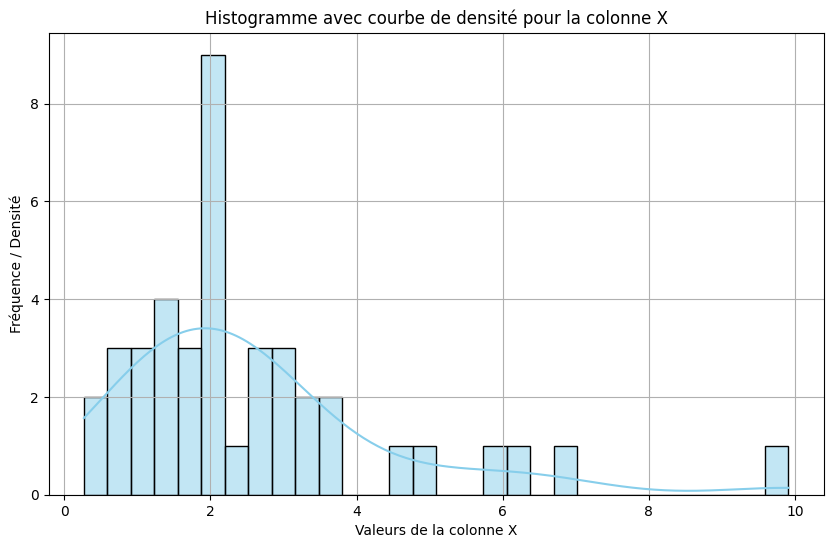

In [71]:
# Exemple pour une colonne spécifique (remplacez 'colonne_x' par votre colonne, ex. 'p21_pop')
plt.figure(figsize=(10, 6))  # Taille du graphique
sns.histplot(data=df, x=df_joined['Densité étudiante'], kde=True, bins=30, color='skyblue')  # Histogramme + densité KDE
plt.title('Histogramme avec courbe de densité pour la colonne X')
plt.xlabel('Valeurs de la colonne X')
plt.ylabel('Fréquence / Densité')
plt.grid(True)
plt.show()


Évaluer le taux de vacance locative en France, et les zones propices à un taux élevé

In [67]:
print("Partie Lucien")

Partie Lucien
